# Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import glob
import pandas as pd

from bs4 import BeautifulSoup
import re

from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

import json

# Загрузка датасета

Распаковка архива

In [3]:
!tar -xzf "/content/drive/MyDrive/aclImdb_v1.tar.gz"

Загрузка обучающей выборки в DataFrame

In [4]:
path = '/content/aclImdb/train'

In [5]:
train_df = pd.DataFrame(columns = ['review', 'sentiment']) # DataFrame для тренировочной выборки

# Чтение и занесение в DataFrame положительных отзывов
for file_name in glob.glob(path + "/pos/*.txt"):
  with open(file_name) as f:
    df = pd.DataFrame({'review' : [f.read()], 'sentiment':['pos']})
    train_df = pd.concat([train_df, df], ignore_index = True)

# Чтение и занесение в DataFrame отрицательных отзывов
for file_name in glob.glob(path + "/neg/*.txt"):
  with open(file_name) as f:
    df = pd.DataFrame({'review' : [f.read()], 'sentiment':['neg']})
    train_df = pd.concat([train_df, df], ignore_index = True)

Загрузка тестовой выборки в DataFrame

In [6]:
path = '/content/aclImdb/test'

In [7]:
test_df = pd.DataFrame(columns = ['review']) # DataFrame для тестовой выборки

# Чтение и занесение в DataFrame положительных отзывов
for file_name in glob.glob(path + "/pos/*.txt"):
  with open(file_name) as f:
    df = pd.DataFrame({'review' : [f.read()], 'sentiment':['pos']})
    test_df = pd.concat([test_df, df], ignore_index = True)

# Чтение и занесение в DataFrame отрицательных отзывов
for file_name in glob.glob(path + "/neg/*.txt"):
  with open(file_name) as f:
    df = pd.DataFrame({'review' : [f.read()], 'sentiment':['neg']})
    test_df = pd.concat([test_df, df], ignore_index = True)

Предобработка текста

In [8]:
# Удаление html-тегов
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Удаление квадратных скобок
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Удаление специальных символов
def remove_special_characters(text):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def prepare_data(text):
  text = strip_html(text)
  text = remove_between_square_brackets(text)
  text = remove_special_characters(text)
  return text

train_df['review'] = train_df['review'].apply(prepare_data)
test_df['review'] = test_df['review'].apply(prepare_data)

Токенизация отзывов

In [9]:
max_words = 10000 # Количество слов в словаре
max_len = 300 # Длина вектора

In [10]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(pd.concat([train_df['review'],test_df['review']], ignore_index=False))

x_train = tokenizer.texts_to_sequences(train_df['review'])
x_train = pad_sequences(x_train, max_len)

x_test = tokenizer.texts_to_sequences(test_df['review'])
x_test = pad_sequences(x_test, max_len)

In [11]:
lb = LabelBinarizer()
y_train = lb.fit_transform(train_df['sentiment'])
y_test = lb.transform(test_df['sentiment'])

# Создание модели

In [12]:
model = Sequential()
model.add(Embedding(max_words, 64, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обучение модели

Использование callbacks

In [13]:
modelCheckpoint = ModelCheckpoint("model.h5",
                                  monitor='val_accuracy',
                                  verbose=2,
                                  save_best_only=True)

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor = 0.2, patience=2, min_lr=0.00001)

In [15]:
callbacks = [modelCheckpoint, reduce_lr]

Процесс обучения

In [16]:
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    callbacks = callbacks,
                    validation_split = 0.2)

Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 0.5067 - accuracy: 0.7506
Epoch 1: val_accuracy improved from -inf to 0.64660, saving model to model.h5
157/157 [==============================] - 113s 694ms/step - loss: 0.5067 - accuracy: 0.7506 - val_loss: 0.6947 - val_accuracy: 0.6466 - lr: 0.0010
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.8832
Epoch 2: val_accuracy improved from 0.64660 to 0.81880, saving model to model.h5
157/157 [==============================] - 107s 681ms/step - loss: 0.2944 - accuracy: 0.8832 - val_loss: 0.4747 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9194
Epoch 3: val_accuracy did not improve from 0.81880
157/157 [==============================] - 112s 714ms/step - loss: 0.2145 - accuracy: 0.9194 - val_loss: 0.4353 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 4/20
157/157 [==============================] - ETA:

Визуализация процесса обучения

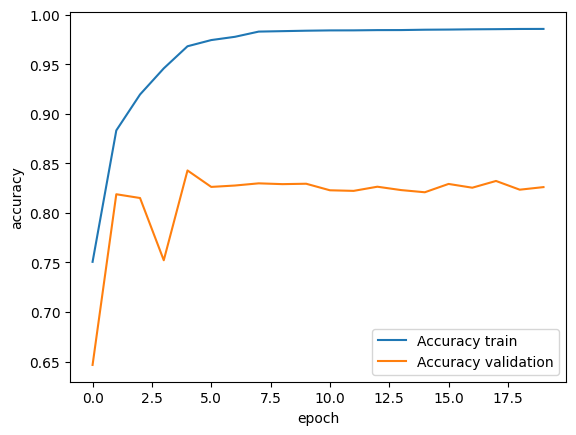

In [17]:
plt.plot(history.history['accuracy'], label='Accuracy train')
plt.plot(history.history['val_accuracy'], label='Accuracy validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Тестирование модели

Загрузка лучших параметров весов

In [18]:
model.load_weights('/content/model.h5')

Тестирование модели на тестовой выборке

In [19]:
scores = model.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 40s 51ms/step - loss: 0.3956 - accuracy: 0.8616


# Сохранение модели и токенайзера

Сохранение модели

In [20]:
model.save('rnn_model.h5')

Сохранение токенайзера

In [21]:
with open('tokenizer.json', 'w') as outfile:
    json.dump(tokenizer.to_json(), outfile)